In [1]:
from __future__ import division
import numpy as np

# import MalmoPython
import malmo.MalmoPython as MalmoPython
import os
import random
import sys
import time
import json
import random
import math
import logging
import errno
import pickle
import matplotlib.pyplot as plt
from collections import defaultdict, deque
from timeit import default_timer as timer

In [2]:
def save_q_table(q_table, filename):
    with open(filename, 'w') as f:
        json.dump(q_table, f)

def load_q_table(filename):
    with open(filename, 'r') as f:
        q_table = json.load(f)
    return q_table

In [3]:
random.seed()
world_num = random.randint(0, 25)
world_map = open('xmls/world_{world_num}.txt'.format(world_num = world_num), 'r')
lines = world_map.readlines()
logs = [] #tuple (block, (x,y,z))
water = []
diamond = []
obs_set = set()

def addObjects(line, block_name, obs_list):
    terms = line.split()
    coords = []

    for i in range(1,7):
        start = terms[i].index('"') + 1
        end = terms[i].index('"', start)
        coords.append(int(terms[i][start:end]))


    if coords[0] < -6: #IF X is OUTSIDE OF OUR DESIRED RANGE -4, 4 we just dip.
        return
    if coords[2] > 30: #IF Z is outside. dip.
        return
    
    if coords[0] == coords[3]:
        x_range = [coords[0]]
    else:
        x_range = [x for x in range(min(coords[0],coords[3]), max(coords[0],coords[3])+ 1)] #do we need + 1 to make range inclusive?
    
    if coords[1] == coords[4]:
        y_range = [coords[1]]
    elif block_name == "diamond_block":
        y_range = [1,2] # WE DON'T NEED TO ADD DIAMOND_BLOCKS THAT HIGHER THAN 6 IN Y-AXIS
    elif coords[4] != coords[1]: #this was initially 4 1 swapped. not sure why?
        y_range = [y for y in range(min(coords[1],coords[4]), max(coords[1],coords[4]))]
    
    if coords[2] == coords[5]:
        z_range = [coords[2]]
    else:
        z_range = [z for z in range(coords[2], coords[5])] #this generally only happens for walls.
    print(coords)

    #this spawns way too many duplicates.
    for x in x_range:
        for y in y_range:
            for z in z_range:
                obs_list.append((block_name, (x, y, z)))
for line in lines:
    if "DrawCuboid" in line:
        if "log" in line:
            addObjects(line, "log", logs)
        if "diamond_block" in line:
            addObjects(line, "diamond_block", diamond)
    if "DrawLine" in line:
        addObjects(line, "water", water)
# print(logs)
# print(diamond)
# print(water)


[-6, 3, -2, 6, 1, 32]
[-4, -3, 30, 4, 15, 31]
[-1, 0, 10, -1, 3, 10]
[3, 0, 21, 3, 3, 21]
[3, 0, 30, 3, 3, 30]
[-1, 0, 22, -1, 3, 22]
[2, 0, 10, 2, 3, 10]
[1, 0, 3, 1, 3, 3]
[1, 1, 25, 1, 1, 25]
[2, 1, 22, -1, 1, 22]
[-2, 1, 4, -3, 1, 4]
[3, 1, 22, 1, 1, 22]
[-1, 1, 18, -2, 1, 18]


In [4]:
# ContinuousMovementCommands
actions_space = ['move 1', 'strafe 1', 'strafe -1', 'jump 1']
# REMINDER: VALUE OF EACH ACTION IS THE SPEED, NOT NUMBER OF TIMES
# move  1    full speed ahead
# move -1    full speed backwards
# strafe 1   moves right at full speed
# strafe -1  moves left at full speed
# turn 1     turns full speed right
# turn -1    turns full speed left
# jump 1/0   starts/stops jumping


INITIAL_LOCATION = (1, 2, 0)
DIAMOND_WALL_Z = 30
INITIAL_DISTANCE = DIAMOND_WALL_Z
reward_map =  {
            'diamond_block': 100,
            'packed_ice': 1,
            'log': -20,
            'water': -2
            }

importantObjects = logs + diamond + water

class Racer(object):
    def __init__(self, alpha=0.3, gamma=1, n=5):
        """Constructing an RL agent.

        Args
            alpha:  <float>  learning rate      (default = 0.3)
            gamma:  <float>  value decay rate   (default = 1)
            n:      <int>    number of back steps to update (default = 5)
        """
        self.epsilon = 0.3  # chance of taking a random action instead of the best
        self.q_table = {}
        self.n, self.alpha, self.gamma = n, alpha, gamma
        self.actions_taken = []
        self.num_actions = 0
        self.reward = 0
        self.diamond_reached = False
        self.obstacles_hit = False
        self.timer = time.time()
        self.logger = logging.getLogger(__name__)
        if False: # True if you want to see more information
            self.logger.setLevel(logging.DEBUG)
        else:
            self.logger.setLevel(logging.INFO)
        self.logger.handlers = []
        self.logger.addHandler(logging.StreamHandler(sys.stdout))
        
    def clear_actions(self):
        """Resets the actions in case of a new iteration to fetch. """
        self.actions_taken = []
        self.num_actions = 0
        self.reward = 0
        self.diamond_reached = False
        self.obstacles_hit = False
        
    def get_possible_actions(self, agent_host, term_flag):
        """Returns all possible actions that can be done at the current state. """
#         print("in get possible actions")
        action_list = []
        if not term_flag:
            action_list.extend(actions_space)
        return action_list
    
    def choose_action(self, curr_state, possible_actions, eps):
        """Chooses an action according to eps-greedy policy. """
        if curr_state not in self.q_table:
            self.q_table[curr_state] = {}
        for action in possible_actions:
            if action not in self.q_table[curr_state]:
                self.q_table[curr_state][action] = 0
        
        rnd = random.random()
        if rnd <= eps:
            a = random.randint(0, len(possible_actions) - 1)
            return possible_actions[a]
        else:
            # copy dict{actions: q-values} of q_table[curr_state]
            state_actions =self.q_table[curr_state]
            # find the max q-value
            max_q = max(state_actions.values())
            # find the list of actions that return the maximum q-value
            max_actions = [action for action, value in state_actions.items() if value == max_q]
            # pick a random action from the max_actions list
            max_rand = random.randint(0, len(max_actions) - 1)
            return max_actions[max_rand]
        
    def get_curr_location(self, agent_host):
        # get the world state
        world_state = agent_host.peekWorldState()
        location = tuple()
        if world_state.number_of_observations_since_last_state > 0:
            msg = world_state.observations[-1].text
            observations = json.loads(msg)
            # get curr location from json
            xpos = observations.get(u'XPos',0)
            ypos = observations.get(u'YPos',0)
            zpos = observations.get(u'ZPos',0)
            location = (xpos, ypos, zpos)
            #print("LOCATION: ", location)
            return location
        else:
            return INITIAL_LOCATION
        
    def get_obj_locations(self, agent_host):
        return logs + water + diamond
    
    def calculate_dist_reward(self, agent_host, currentState, timer):
        #agent_z = self.get_curr_location(agent_host)[2]
        agent_z = currentState[2]
        dist_from_wall = DIAMOND_WALL_Z -agent_z
        dist_traveled = INITIAL_DISTANCE - dist_from_wall
#         print("traveled: ", dist_traveled)
#         print("Dist From Wall: ", dist_from_wall)
        reward = math.floor((dist_traveled*100)/INITIAL_DISTANCE)
        if self.diamond_reached == True:
            time_elapsed = time.time() - timer #find current runtime, minus time of starting.
            reward += 200 // time_elapsed
#             print("bonus reward: ", reward)
        return reward
    
    def eval_current_state(self, agent_host, current_state, timer):
#         print("current_state passed in eval:", current_state)
        #maybe need to set obstacles hit and diamond to false? but since its in a class shud be ok.
        agent_loc = self.get_curr_location(agent_host)
#         print("agent_loc =", agent_loc)
        nearby_objects = self.get_obj_locations(agent_host)
        reward = self.calculate_dist_reward(agent_host, current_state, timer) 
        ######################################## MOVING THIS DOWN TO ACCOUNT FOR TIMER!!
        for obj in nearby_objects:
            obj_type, obj_loc = obj
            obj_x, obj_y, obj_z = obj_loc

            # Check for logs
            if obj_type == 'log':
#                 print("log loc =", obj_loc)
#                 print("agent loc =", current_state)
                if obj_z >= current_state[2] - 0.3 and obj_z <= current_state[2] + 0.3:
#                     print("log loc =", obj_loc)
#                     print("agent loc =", current_state)
                    if obj_x >= current_state[0] - 0.1 and obj_x <= current_state[0] + 0.1:
#                         print("log loc =", obj_loc)
#                         print("agent loc =", current_state)
                        #reward += reward_map['log']
#                         print('we hit a log lol z and x: ', reward)
                        self.obstacles_hit = True
                        time.sleep(0.2) #adding this to pause the overdoing of collision reward dropping.
                '''
                The below condition seems problematic but the agent seems to be performing
                very well with it for some reason. I have tried both current_state[1] -1 and current_state[1].
                But it seems like the agent is most likely to hit the wall faster with current_state[1].
                '''
                if obj_y == current_state[1]:
                # if obj_y == current_state[1] - 1:

                    #reward += reward_map['log']
                    #print('we hit a log lol y: ', reward)
                    self.obstacles_hit = True

            # Check for diamonds
            elif obj_type == 'diamond_block' and obj_z >= current_state[2] and obj_z <= current_state[2] + 1:
                #reward = reward_map['diamond_block'] #I feel like this should just be reward = 
                self.diamond_reached = True
#                 print('we hit diamond!!')
                time.sleep(0.2)
            # Check for water
            elif obj_type == 'water' and obj_z >= current_state[2] and obj_z <= current_state[2] + 1:
                if obj_x >= current_state[0] - 1.5 and obj_x <= current_state[0] + 1.5:
                    reward += reward_map['water']
#                     print('puddle lol: ', self.reward)
        
        if self.obstacles_hit:
            reward += reward_map['log']
        if self.diamond_reached:
            #Instead of commenting out reward, in the case of a diamond getting hit we will just reset it.
            reward = self.calculate_dist_reward(agent_host, current_state, timer)
            reward += reward_map['diamond_block']
        return reward, self.diamond_reached, self.obstacles_hit
    
    def act(self, agent_host, action, timer): 
        #lowkey set up an action queue so we dont need
        # to hardcode the jumpXmove action. if we have a while loop that just
        #runs and constantly time.sleeps() per game state update, we would be able to jump/run
        #without more problems. this should be fine for now. The code is just a little messier.
#         print(action + ",", end = " ")
        self.actions_taken.append(action)

        term, size = action.split()
        if term == 'jump': #pair it with move 1.
            agent_host.sendCommand('move 1')
            self.actions_taken.append('move 1')
        term += ' 0'
        
        agent_host.sendCommand(action) #GO
        time.sleep(0.4)
        if term == 'jump 0': #pair it with move 1.
            agent_host.sendCommand('move 0')
            self.actions_taken.append('move 0')
        agent_host.sendCommand(term)  #STOP
        
        # reevaluate the current state after action
#         print('call current location in act')
        curr_state = self.get_curr_location(agent_host)
        if curr_state not in self.q_table:
            self.q_table[curr_state] = {}
        possible_actions = self.get_possible_actions(agent_host, False)
        for action in possible_actions:
            if action not in self.q_table[curr_state]:
                self.q_table[curr_state][action] = 0                
        
        # high emphasis on this part since it greatly affects the flow of the entire mission
        self.prev_s = curr_state
        self.prev_a = action
        
        current_reward = self.eval_current_state(agent_host, curr_state, timer)[0]
           
        return current_reward, self.diamond_reached, self.obstacles_hit
    
    def update_q_table_without_tau(self, S, A, R, T):
        """Performs relevant updates for the Q-values.
        TD(0) implementation of SARSA algorithm. Better for this use case.
        Args
            S:   <deque>   states queue
            A:   <deque>   actions queue
            R:   <deque>   rewards queue
            T:   <int>      terminating state index

        """
        G = 0
#         print("R =", R)
#         print("S =", S)
#         print("A =", A)
        for i in range(len(S)-2, -1, -1):
#             print("i =", i)
            G = self.gamma * G + R[i + 1]
            old_q = self.q_table[S[i]][A[i]]
            self.q_table[S[i]][A[i]] = old_q + self.alpha * (G - old_q)
            
    def updateQTableFromTerminatingState(self, reward):
        """Change q_table to reflect what we have learnt, after reaching a terminal state."""
        
        # retrieve the old action value from the Q-table (indexed by the previous state and the previous action)
        old_q = self.q_table[self.prev_s][self.prev_a]
        
        # TODO: what should the new action value be?
        new_q = old_q
        
        # assign the new action value to the Q-table
        self.q_table[self.prev_s][self.prev_a] = new_q
        
        
    def run(self, agent_host, start_time): 
        """Learns the process to reach the diamonds"""
        S, A, R = deque(), deque(), deque()
        total_reward = 0
        present_reward = 0
        done_update = False
        self.prev_s = None
        self.prev_a = None
        
        is_first_action = True
    
        world_state = agent_host.getWorldState()
        while world_state.is_mission_running:
            T = sys.maxsize
            present_reward = 0
            
            if is_first_action:
                # wait until we have received a valid observation
                while True:
                    time.sleep(0.1)
                    world_state = agent_host.getWorldState()
                    
                    # scope for any errors that may occur in the world state
                    for error in world_state.errors:
                        self.logger.error("Error: %s" % error.text)
                        
                    # gather rewards for any found in world state
                    for reward in world_state.rewards:
                        present_reward += reward.getValue()
                         
                    # where the actual actions take place
                    if world_state.is_mission_running and len(world_state.observations)>0 and not world_state.observations[-1].text=="{}":
                        term_flag = self.diamond_reached or self.obstacles_hit
                        
                        possible_actions = self.get_possible_actions(agent_host, term_flag)
                        
                        s0 = self.get_curr_location(agent_host)
                        a0 = self.choose_action(s0, possible_actions, self.epsilon)
                        
                        S.append(s0)
                        A.append(a0)
                        R.append(0) # should we append returned_reward for a0 after self.act??
                        
#                         print("taking action: ", a0)
                        # agent_host.sendCommand(a0);
                        
                        returned_reward, diamond_reached, obstacles_hit = self.act(agent_host, a0,start_time)
                        time.sleep(0.2)
#                         print("returned_reward: ", returned_reward)
#                         print("diamond_reached: ", diamond_reached)
#                         print("obstacles_hit?? ", obstacles_hit)
#                         print("self.obstacles_hit =", self.obstacles_hit)
                        R.append(returned_reward)
                        
                        term_flag = self.diamond_reached or self.obstacles_hit
#                         print("term flag =", term_flag)
                        
                        total_reward += returned_reward
                        # update Q values
#                         print("S =", S)
#                         print("A =", A)
#                         print("R =", R)
                        if not term_flag and self.prev_s is not None and self.prev_a is not None:
                            self.update_q_table_without_tau(S, A, R, T)
                        
                        # Terminating state
                        # no need to go any further if we hit certain obstacle or goal
                        # not using tau values for this implementation
                        if term_flag:
                            # we should be calculating reward if it hits a log.
                            present_reward = returned_reward  # either = or +=
#                             print("Reward:", present_reward)
                            
#                             while len(S) > 1:
#                                 self.update_q_table_without_tau(S, A, R, T)
                            
                            # process final reward
                            self.logger.debug("Final reward: %d" % present_reward)
                            total_reward += present_reward

                            # update Q values
                            if self.prev_s is not None and self.prev_a is not None:
#                                 self.updateQTableFromTerminatingState( present_reward )
                                self.update_q_table_without_tau(S, A, R, T)

                            return total_reward       
                        else:
                            s = self.get_curr_location(agent_host)
                            S.append(s)
                            possible_actions = self.get_possible_actions(agent_host, term_flag)
                            next_a = self.choose_action(s, possible_actions, self.epsilon)
                            A.append(next_a)
                        
                        break
                    
                    if not world_state.is_mission_running:
                        break
#                 print("first!!")
                is_first_action = False
            else:
                # wait for non-zero reward
                ##############################################################
#                 while world_state.is_mission_running and present_reward == 0:
#                     time.sleep(0.1)
#                     print("NO CAPPP")
#                     world_state = agent_host.getWorldState()
                    
#                     # scope for any errors that may occur in the world state
#                     for error in world_state.errors:
#                         self.logger.error("Error: %s" % error.text)
                        
#                     # gather rewards for any found in world state
#                     for reward in world_state.rewards:
#                         present_reward += reward.getValue()
                ##############################################################

                # allow time to stabilise after action
                while True:
                    time.sleep(0.1)
                    world_state = agent_host.getWorldState()
                    
                    # scope for any errors that may occur in the world state
                    for error in world_state.errors:
                        self.logger.error("Error: %s" % error.text)
                        
                    # gather rewards for any found in world state
                    for reward in world_state.rewards:
                        present_reward += reward.getValue()
                    
                    # where the actual actions take place
                    if world_state.is_mission_running and len(world_state.observations)>0 and not world_state.observations[-1].text=="{}":
                        term_flag = self.diamond_reached or self.obstacles_hit
                        
                        s = self.get_curr_location(agent_host)
                        S.append(s)
                        possible_actions = self.get_possible_actions(agent_host, term_flag)
                        next_a = self.choose_action(s, possible_actions, self.epsilon)
                        A.append(next_a)
                        
#                         print("taking action: ", a0)
                        # agent_host.sendCommand(a0);
                        
                        returned_reward, diamond_reached, obstacles_hit = self.act(agent_host, a0,start_time)
                        time.sleep(0.2)
#                         print("returned_reward: ", returned_reward)
#                         print("diamond_reached: ", diamond_reached)
#                         print("obstacles_hit?? ", obstacles_hit)
                        
                        term_flag = self.diamond_reached or self.obstacles_hit
#                         print("term flag =", term_flag)
                        
                        total_reward += returned_reward
                        R.append(returned_reward)
                        # update Q values
                        if not term_flag and self.prev_s is not None and self.prev_a is not None:
                            self.update_q_table_without_tau(S, A, R, T)
                        
                        # Terminating state
                        # no need to go any further if we hit certain obstacle or goal
                        # not using tau values for this implementation
                        if term_flag:
                            # we should be calculating reward if it hits a log.
                            present_reward = returned_reward  # either = or +=
#                             print("Reward:", present_reward)
                            
#                             while len(S) > 1:
#                                 self.update_q_table_without_tau(S, A, R, T)
                            
                            # process final reward
                            self.logger.debug("Final reward: %d" % present_reward)
                            total_reward += present_reward

                            # update Q values
                            if self.prev_s is not None and self.prev_a is not None:
#                                 self.updateQTableFromTerminatingState( present_reward 
                                self.update_q_table_without_tau(S, A, R, T)
                            return total_reward       
                        
                        break
                    
                    if not world_state.is_mission_running:
                        break
    
        # process final reward
        self.logger.debug("Final reward: %d" % present_reward)
        total_reward += present_reward

        # update Q values
        if self.prev_s is not None and self.prev_a is not None:
            self.updateQTableFromTerminatingState( present_reward )
            
#         print("diamond_reached: ", diamond_reached)
                
        return total_reward

In [5]:
if __name__ == '__main__':
    #sys.stdout = os.fdopen(sys.stdout.fileno(), 'w', 0)  # flush print output immediately
    print('Starting...', flush=True)
    q_table_save_frequency = 1  # save the Q-table after every 100 iterations
    q_table_file = "q_table.pckl"
    
    my_client_pool = MalmoPython.ClientPool()
    my_client_pool.add(MalmoPython.ClientInfo("127.0.0.1", 10000))

    agent_host = MalmoPython.AgentHost()
    try:
        agent_host.parse(sys.argv)
    except RuntimeError as e:
        print('ERROR:', e)
        print(agent_host.getUsage())
        exit(1)
    if agent_host.receivedArgument("help"):
        print(agent_host.getUsage())
        exit(0)
    
    print(world_num)  # defined above when finding obstacle coords
    mission_file = 'xmls/world_{world_num}.txt'.format(world_num = world_num)

    with open(mission_file, 'r') as f:
        print("Loading mission from %s" % mission_file)
        missionXML = f.read()

    
    num_reps = 25
    n=10
    run_times = []
    finished_track = []
    actions_taken = []
    
    racer = Racer(n=n)
    
    '''
    alpha:  <float>  learning rate      (default = 0.3)
    gamma:  <float>  value decay rate   (default = 1)
    n:      <int>    number of back steps to update   (default = 5)
    epsilon <int>    chance of taking a random action instead of the best   (default = 0.3)
    '''
    racer.epsilon = 0.3  # for testing purposes
    racer.alpha = 0.3
    racer.gamma = 1
    racer.n = n
    
    print("n=", racer.n)
    print("epsilon=", racer.epsilon)
    print("alpha=", racer.alpha)
    print("gamma=", racer.gamma)        
        
    racer.clear_actions()
    
    cumulative_rewards = []
    for iRepeat in range(num_reps):
        my_mission = MalmoPython.MissionSpec(missionXML, True)
        my_mission_record = MalmoPython.MissionRecordSpec()  # Records nothing by default
        my_mission.requestVideo(1260, 960)
        my_mission.setViewpoint(0)
        
        # attempt to start a mission
        max_retries = 3
        for retry in range(max_retries):
            try:
                agent_host.startMission( my_mission, my_client_pool, my_mission_record, 0, "Racer")
                break
            except RuntimeError as e:
                if retry == max_retries - 1:
                    print("Error starting mission", e)
                    print("Is the game running?")
                    exit(1)
                else:
                    time.sleep(2)

        # Loop until mission starts:
        print("\nWaiting for the mission to start on trial", iRepeat+1)
        world_state = agent_host.getWorldState()
        
        while not world_state.has_mission_begun:
            time.sleep(0.1)
            world_state = agent_host.getWorldState()
            
            for error in world_state.errors:
                print("Error:",error.text) 
                
        print("Mission running...")
        
        # log time for each run
        start_time = time.time()
        
        cumulative_reward = racer.run(agent_host, start_time)
        print('Cumulative reward: %d' % cumulative_reward)
        cumulative_rewards += [ cumulative_reward ]
        
        time_elapsed = time.time() - start_time
        print("--- %s seconds ---" % (time_elapsed))
        run_times.append(time_elapsed)
        
        print("diamond reached? ", racer.diamond_reached)
        finished_track.append(racer.diamond_reached)
        
        
#         with open('q_table.pckl', 'wb') as f:
#             pickle.dump(racer.q_table, f)
#         print('Q-table saved.')
#         with open('q_table.pkl', 'rb') as read_q:
#             q_table = pickle.load(read_q)
#             print(q_table)

#         print(racer.actions_taken)
        actions_taken.append(racer.actions_taken)
    
        racer.clear_actions()
        time.sleep(1)
        

print("\n\nMission ended.")
print("Cumulative rewards for all %d runs:" % num_reps)
print(cumulative_rewards)

print("\nRun times for all %d runs in seconds:" % num_reps)
print(run_times)

for i in range(0, num_reps):
    print("\nAgent had overall score of %s on trial %s with a run time of %.4f seconds. finished track? %s " % (cumulative_rewards[i], i+1, run_times[i], finished_track[i]))

Starting...
ERROR: Caught std::exception: unrecognised option '-f'

Malmo version: 0.36.0

Allowed options:
  -h [ --help ]         show description of allowed options
  --test                run this as an integration test


23
Loading mission from xmls/world_23.txt
n= 10
epsilon= 0.3
alpha= 0.3
gamma= 1

Waiting for the mission to start on trial 1
Mission running...
Cumulative reward: -34
--- 0.903296947479248 seconds ---
diamond reached?  False
Error starting mission A mission is already running.
Is the game running?

Waiting for the mission to start on trial 2
Mission running...
Cumulative reward: -34
--- 1.104252576828003 seconds ---
diamond reached?  False
Error starting mission A mission is already running.
Is the game running?

Waiting for the mission to start on trial 3
Mission running...
Cumulative reward: -34
--- 0.7029111385345459 seconds ---
diamond reached?  False
Error starting mission A mission is already running.
Is the game running?

Waiting for the mission to start o

Plotting time elapsed per run (sec)...
n= 10
epsilon= 0.3
alpha= 0.3
gamma= 1


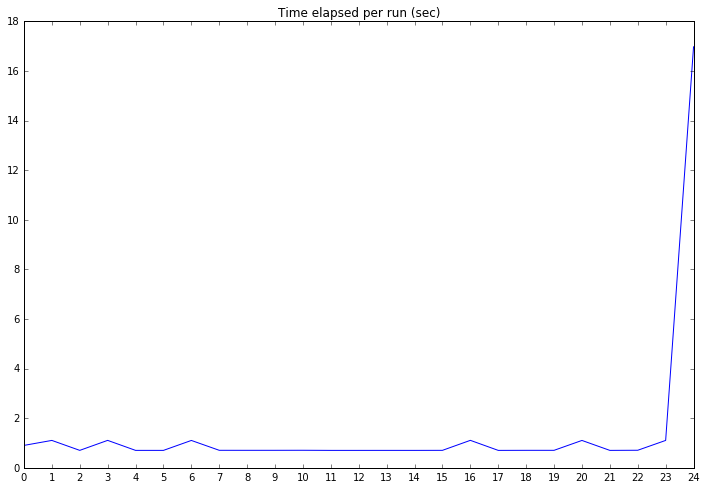

In [6]:
print("Plotting time elapsed per run (sec)...")
print("n=", racer.n)
print("epsilon=", racer.epsilon)
print("alpha=", racer.alpha)
print("gamma=", racer.gamma) 

x = []
for i in range(num_reps):
    x.append(i)

plt.figure(figsize=(num_reps//2, 8));
plt.xticks(x);
plt.title("Time elapsed per run (sec)")
plt.plot(x, run_times)
plt.show();

Plotting total reward per run...
n= 10
epsilon= 0.3
alpha= 0.3
gamma= 1


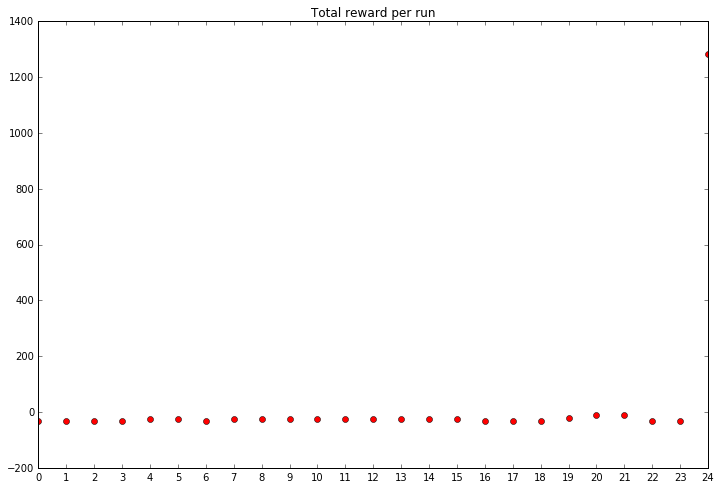

In [7]:
print("Plotting total reward per run...")
print("n=", racer.n)
print("epsilon=", racer.epsilon)
print("alpha=", racer.alpha)
print("gamma=", racer.gamma)  

x = []
for i in range(num_reps):
    x.append(i)

plt.figure(figsize=(num_reps//2, 8));
plt.xticks(x);
plt.title("Total reward per run")
plt.plot(x, cumulative_rewards, 'ro')
plt.show();

Plotting number of actions taken per run...
n= 10
epsilon= 0.3
alpha= 0.3
gamma= 1


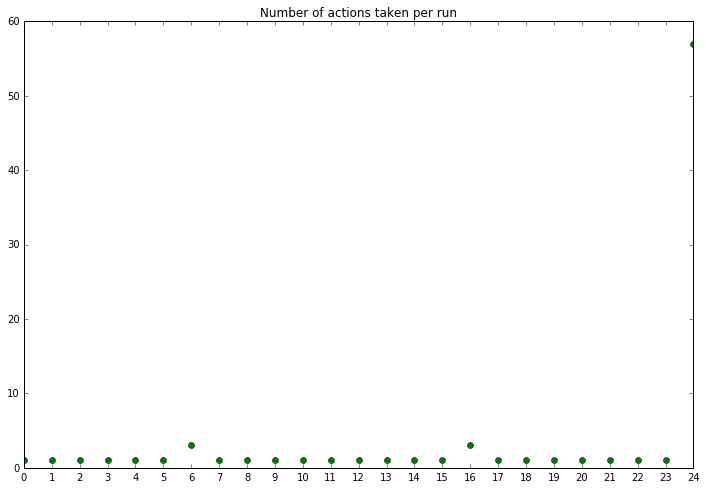

In [8]:
print("Plotting number of actions taken per run...")
print("n=", racer.n)
print("epsilon=", racer.epsilon)
print("alpha=", racer.alpha)
print("gamma=", racer.gamma)  

x = []
for i in range(num_reps):
    x.append(i)
    
y = []
for i in range(len(actions_taken)):
    y.append(len(actions_taken[i]))

plt.figure(figsize=(num_reps//2, 8));
plt.xticks(x)
plt.title("Number of actions taken per run")
plt.plot(x, y, 'go')
plt.show();